### Podcast Reviews - [2 million reviews on 100k podcasts](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28)
***
#### <u>Overarching Investigation:
#### -_What categories of podcasts are popular?_
#### -_What makes a 5-star podcast? What makes a 1-star podcast?_
#### -_How do reviewer tendencies vary and differ?_
***
#### Technical Goals:
##### 1. Working with a SQLite Database
##### 2. Using Python-based Data Analysis Packages such as Pandas
##### 3. Data Visualization
##### 4. Hypothesis Testing and Statistical Inference
##### 5. [Making a Dashboard](https://lookerstudio.google.com/reporting/4b70c021-6318-464d-aacb-676f92817f84)
--- 

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from utils.podcast_utils import (
    bootstrap_confidence_interval_two_means,
    extract_supercategory,
    grouping,
    mean_diff_permutation,
    proportion_diff_permutation,
    query_to_df,
    see_tables,
)
from scipy.stats import chi2_contingency, chisquare, wilcoxon

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["axes.edgecolor"] = "black"

sns.set_style("white")
sns.set_palette("colorblind")
sns.set_context("notebook")

*** 
__Accessing the Database & First Looks at the Data__

steps:<br>
1. make sure you have a "data" folder
2. Download the data from [Kaggle](https://www.kaggle.com/datasets/thoughtvector/podcastreviews/versions/28)
3. Unzip the folder
4. Ensure that the file "database.sqlite" can be found in the data folder

Running the cell below will create the data folder for you. <br>

In [3]:
os.makedirs('data', exist_ok=True)

I recommend downloading the database yourself through the link provided above as I ran into unexpected errors using the KaggleAPI with this particular database. However, see previous projects of mine such as "mental_health_tech_survey" to see how to use the Kaggle API for automated data downloading. 

At this point, I assume that you have downloaded the data frome Kaggle and placed the file "database.sqlite" into the newly created "data" folder<br><br>

In [4]:
db = "./data/database.sqlite"

In [5]:
tables = see_tables(db)

The tables in the current database are: "runs, podcasts, categories, reviews".


examples of code that I used to look at database tables would include:
```Python
query_to_df("select * from runs limit 10")
query_to_df("select * from podcasts limit 10")
query_to_df("select * from categories limit 10")
query_to_df("select * from reviews limit 10")
```
*** 
### What are the various podcast categories?

In [6]:
categories_query = """
                   SELECT podcast_id, 
                          GROUP_CONCAT(category) as categories 
                   FROM categories 
                   GROUP BY podcast_id
                   """
categories_table = query_to_df(categories_query, database=db)
categories_table

,podcast_id,categories
0,a00018b54eb342567c94dacfb2a3e504,business
1,a00043d34e734b09246d17dc5d56f63c,"christianity,religion-spirituality"
2,a0004b1ef445af9dc84dad1e7821b1e3,"religion-spirituality,spirituality"
3,a00071f9aaae9ac725c3a586701abf4d,"business,business-investing"
4,a000a500f06555f81220c3eb641aded7,news-entertainment-news
...,...,...
110019,ffff32caeedd6254573ad1cc49852595,"news,news-daily-news"
110020,ffff5db4b5db2d860c49749e5de8a36d,"arts,arts-books"
110021,ffff66f98c1adfc8d0d6c41bb8facfd0,comedy
110022,ffff923482740bc21a0fe184865ec2e2,education


In [7]:
categories_table["supercategory"] = categories_table["categories"].apply(
    extract_supercategory
)
categories_table["supercategory"] = categories_table["supercategory"].apply(grouping)
categories_table

,podcast_id,categories,supercategory
0,a00018b54eb342567c94dacfb2a3e504,business,business
1,a00043d34e734b09246d17dc5d56f63c,"christianity,religion-spirituality",spirituality
2,a0004b1ef445af9dc84dad1e7821b1e3,"religion-spirituality,spirituality",spirituality
3,a00071f9aaae9ac725c3a586701abf4d,"business,business-investing",business
4,a000a500f06555f81220c3eb641aded7,news-entertainment-news,news-government
...,...,...,...
110019,ffff32caeedd6254573ad1cc49852595,"news,news-daily-news",news-government
110020,ffff5db4b5db2d860c49749e5de8a36d,"arts,arts-books",arts
110021,ffff66f98c1adfc8d0d6c41bb8facfd0,comedy,comedy
110022,ffff923482740bc21a0fe184865ec2e2,education,education


In [8]:
categories_counts = categories_table["supercategory"].value_counts()
categories_counts = categories_counts.reset_index()
categories_counts

,supercategory,count
0,arts,19776
1,business,12414
2,comedy,11964
3,spirituality,11507
4,society-culture,11198
5,education,9856
6,sports,7405
7,health,6545
8,news-government,5792
9,leisure,5613


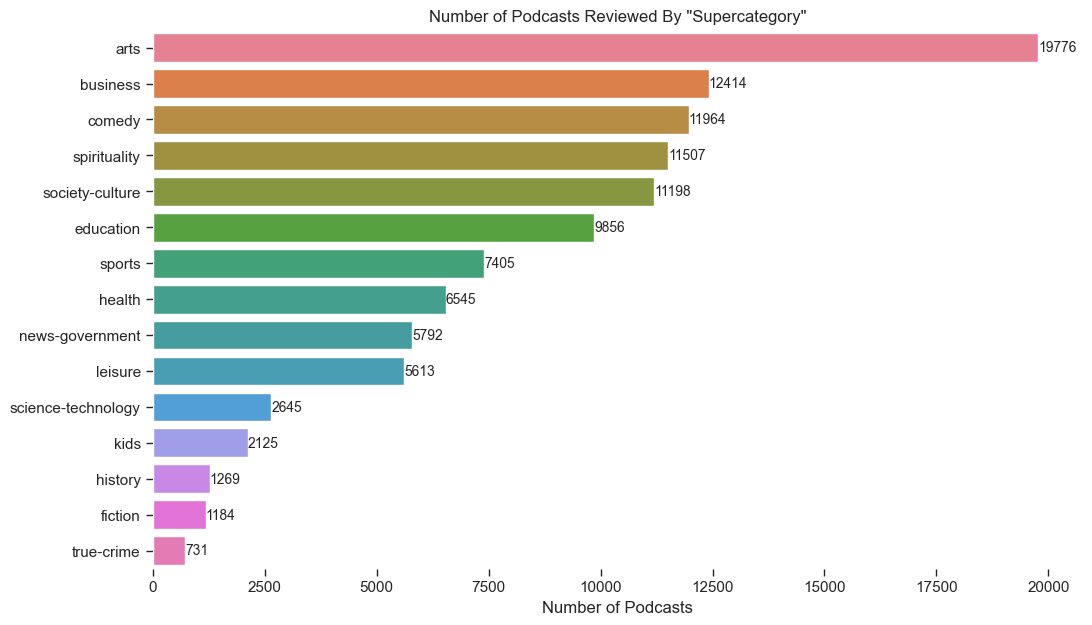

In [9]:
plt.figure(figsize=(12, 7))

ax = sns.barplot(
    data=categories_counts,
    x="count",
    y="supercategory",
    hue="supercategory",
    orient="h",
    dodge=False
)
for container in ax.containers:
    ax.bar_label(container, fontsize=10)

plt.title('Number of Podcasts Reviewed By "Supercategory"')
plt.ylabel("")
plt.xlabel("Number of Podcasts")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

plt.show()

__Are some categories truly more popular than others?__ <br>
Clearly we can see this, but to test this simple hypothesis statistically we could invoke a Chi-Squared Analysis to compare these counts to a model of uniformity. 

In [10]:
chi_2, p = chisquare(f_obs=categories_counts["count"])
print(
    f"""
    According to a Chi-Squared test against the uniform distribution, the current data is distributed
    with a Chi-Squared Statistic = {chi_2:.3f}, p<0.001 (i.e. p = {p}).
    """
)


    According to a Chi-Squared test against the uniform distribution, the current data is distributed
    with a Chi-Squared Statistic = 56448.429, p<0.001 (i.e. p = 0.0).
    


__Interim summary__:<br> 
Compared to a uniform model where data is the same in all categories, it appears that there is very significant preferences to review specific podcasts with arts podcasts being the most represented and true-crime being the least represented. Next, we will investigate how different categories of podcasts are rated.

# Ratings Analysis

In [11]:
rating_query = """
        SELECT p.title as podcast_name,
               r.content as review_content,
               r.author_id as reviewer,
               AVG(r.rating) as rating,
               GROUP_CONCAT(c.category) as categories
        FROM podcasts p 
        JOIN reviews r 
        ON p.podcast_id = r.podcast_id
        JOIN categories c
        ON c.podcast_id = p.podcast_id
        GROUP BY p.title, r.title, r.content
        """

main_ratings_df = query_to_df(rating_query)

main_ratings_df["supercategory"] = main_ratings_df["categories"].apply(
    extract_supercategory
)
main_ratings_df["supercategory"] = main_ratings_df["supercategory"].apply(grouping)
del main_ratings_df["categories"]
main_ratings_df = main_ratings_df.rename(columns={"supercategory": "category"})
main_ratings_df

,podcast_name,review_content,reviewer,rating,category
0,! Weird Rap Podcast !,"It’s my podcast, so probably not the most obje...",199C3835F333D11,5.0,arts
1,! Weird Rap Podcast !,In 1999 I listened to Livin’ Astro on repeat u...,61ED6D289B34165,5.0,arts
2,! Weird Rap Podcast !,CHOKING VICTIM. 🕯\n\n ...,61ED6D289B34165,5.0,arts
3,! Weird Rap Podcast !,This is a side of hip hop that needs more expo...,9FB47600CF3E273,5.0,arts
4,! Weird Rap Podcast !,Super intelligent discussions etc about a broa...,D94D81A696EE91B,5.0,arts
...,...,...,...,...,...
2041748,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,I love this but can u do fav crime PLZ 🥺🙏🏼,F460771CCF036E4,5.0,arts
2041749,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,"Lovely!, it kinda sound sad to me but over all...",ABBA758F55A4124,5.0,arts
2041750,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Your Olivia Rodrigo are really good.,3AE7C274696E9E3,5.0,arts
2041751,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Do favorite crime please! But although I love ...,46EB6E624033FE9,5.0,arts


*** 
__save main_ratings_df for later use__

In [12]:
# save for later use
main_ratings_df.to_parquet("./data/main_ratings_df.parquet", engine="pyarrow")

In [13]:
# can load in dataframe if needed
main_ratings_df = pd.read_parquet("./data/main_ratings_df.parquet", engine="pyarrow")
main_ratings_df

,podcast_name,review_content,reviewer,rating,category
0,! Weird Rap Podcast !,"It’s my podcast, so probably not the most obje...",199C3835F333D11,5.0,arts
1,! Weird Rap Podcast !,In 1999 I listened to Livin’ Astro on repeat u...,61ED6D289B34165,5.0,arts
2,! Weird Rap Podcast !,CHOKING VICTIM. 🕯\n\n ...,61ED6D289B34165,5.0,arts
3,! Weird Rap Podcast !,This is a side of hip hop that needs more expo...,9FB47600CF3E273,5.0,arts
4,! Weird Rap Podcast !,Super intelligent discussions etc about a broa...,D94D81A696EE91B,5.0,arts
...,...,...,...,...,...
2041748,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,I love this but can u do fav crime PLZ 🥺🙏🏼,F460771CCF036E4,5.0,arts
2041749,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,"Lovely!, it kinda sound sad to me but over all...",ABBA758F55A4124,5.0,arts
2041750,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Your Olivia Rodrigo are really good.,3AE7C274696E9E3,5.0,arts
2041751,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Do favorite crime please! But although I love ...,46EB6E624033FE9,5.0,arts


*** 
## How are different podcast categories rated on average? <br>
First, how are podcasts rated in general?

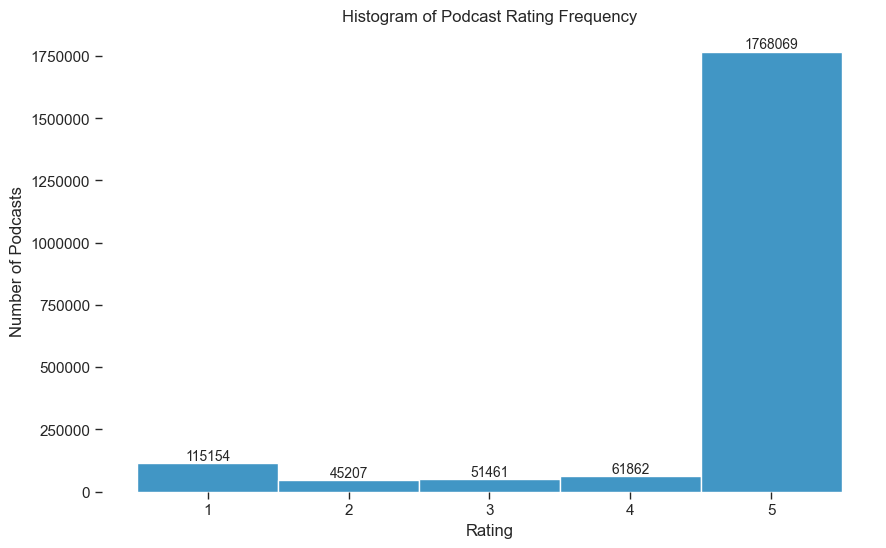

In [14]:
plt.figure(figsize=(10, 6))

ax = sns.histplot(data=main_ratings_df, x="rating", bins=5, discrete=True)
for container in ax.containers:
    ax.bar_label(container, fmt="%d", fontsize=10)

plt.title("Histogram of Podcast Rating Frequency")
plt.ticklabel_format(style="plain", axis="y")
plt.xlabel("Rating")
plt.ylabel("Number of Podcasts")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

plt.show()

In [15]:
ratings_descrip_stats = (
    main_ratings_df[["category", "rating"]].groupby("category").describe()
)
ratings_descrip_stats

rating                                             
                       count      mean       std  min  25%  50%  75%  max
category                                                                 
arts                273566.0  4.688119  0.944416  1.0  5.0  5.0  5.0  5.0
business            217548.0  4.844347  0.691772  1.0  5.0  5.0  5.0  5.0
comedy              330270.0  4.623074  1.067486  1.0  5.0  5.0  5.0  5.0
education           151296.0  4.811187  0.744992  1.0  5.0  5.0  5.0  5.0
fiction              26217.0  4.557463  1.084992  1.0  5.0  5.0  5.0  5.0
health              123133.0  4.813165  0.746229  1.0  5.0  5.0  5.0  5.0
history              46960.0  4.465247  1.197178  1.0  5.0  5.0  5.0  5.0
kids                 51863.0  4.690868  0.937029  1.0  5.0  5.0  5.0  5.0
leisure              76428.0  4.740645  0.867073  1.0  5.0  5.0  5.0  5.0
news-government     159788.0  4.253905  1.413146  1.0  4.0  5.0  5.0  5.0
science-technology   39266.0  4.470271  1.203290  1.0  5.0  5.0  5.0  5.0
society-culture     211212.0  4.438588  1.250794  1.0  5.0  5.0  5.0  5.0
spirituality        116087.0  4.817387  0.753732  1.0  5.0  5.0  5.0  5.0
sports              144857.0  4.611707  1.074105  1.0  5.0  5.0  5.0  5.0
true-crime           73262.0  4.219514  1.408807  1.0  4.0  5.0  5.0  5.0

In [16]:
category_ratings = main_ratings_df[["category", "rating"]]

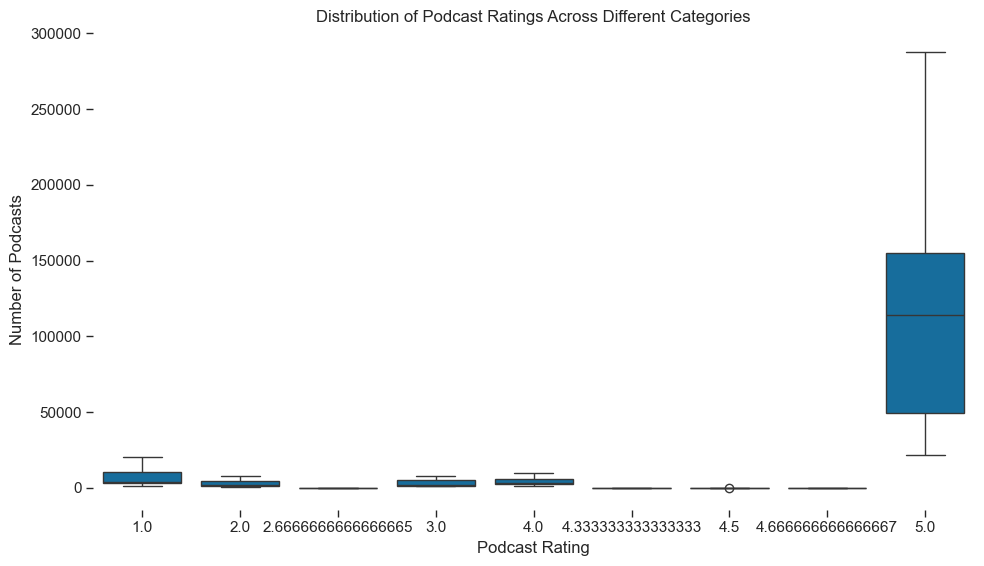

In [17]:
category_counts = category_ratings.groupby("category").value_counts().reset_index()
ax = sns.boxplot(data=category_counts, x="rating", y="count")
ax.set_xlabel("Podcast Rating")
ax.set_ylabel("Number of Podcasts")
plt.suptitle("")
plt.title("Distribution of Podcast Ratings Across Different Categories")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

plt.tight_layout()
plt.show()

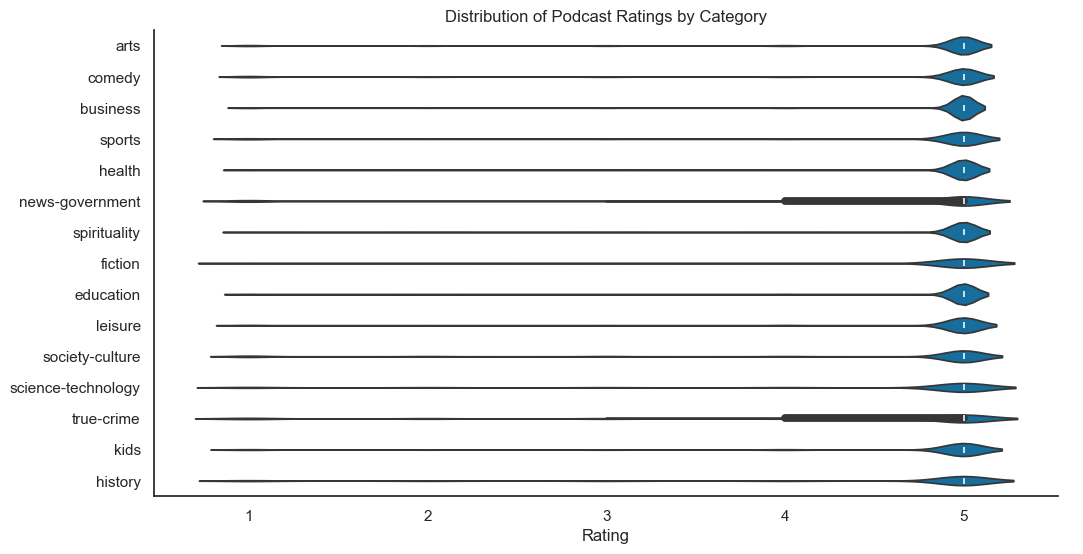

In [18]:
sns.catplot(
    data=category_ratings, x="rating", y="category", kind="violin", height=5.5, aspect=2
)

plt.title("Distribution of Podcast Ratings by Category")
plt.xlabel("Rating")
plt.ylabel("")

sns.despine(left=False, bottom=False, right=True, top=True)

plt.show()

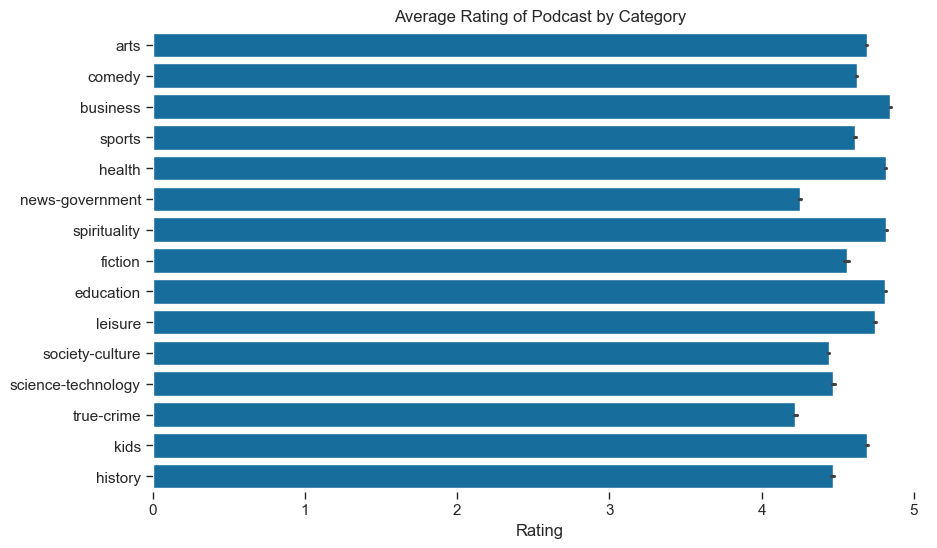

In [80]:
ax = sns.barplot(data=category_ratings, x="rating", y="category")
plt.title("Average Rating of Podcast by Category")
plt.xlabel("Rating")
plt.ylabel("")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

plt.show()

__interim summary__:
- In general, 5-star ratings predominate the charts across all categories
- There is some variability across categories, but generally speaking most ratings are 5 star
- There is more 1-star ratings than 2, 3, or 4
- true-crime is the worst rated whereas business is the best rated

*** 
__Case Study: Compare podcasts about the Arts to podcasts about the News & Government__<br>
Compare the population mean difference between two independent populations of podcasts ratings using the sample that we have collected. 

The target populations are as follows

_Population 1_: podcast ratings of all Arts podcasts <br>
_Population 2_: podcast ratings of all News & Government podcasts

Performing a descriptive analysis of the sample mean ratings to hypothesize about the population mean difference. 

I believe that Arts podcasts will have higher mean ratings than News & Government podcasts. Yet, to assess this question I will perform a two-tailed test to be conservative. 

$H_{0}$: Mean Arts Podcast Rating = Mean News & Government Podcast Rating <br>
$H_{a}$: Mean Arts Podcast Rating $\neq$ Mean News & Government Podcast Rating

stated another way:<br> 
$H_{0}$: Mean Rating Difference = 0 (no difference) <br>
$H_{a}$: Mean Rating Difference $\neq$ 0 (some difference)

Parameter of Interest:$\mu_{1}$ - $\mu_{2}$

$\alpha$-level: 0.05

The assumptions to compare two population means:
- 2 simple random samples (NOT LIKELY since reviewers are self-selecting, but we can assume this for the sake of demonstration)
- samples independent of one another (POTENTIALLY TRUE, I labelled these categories independently of one another. However, I will need to filter out reviewers who are in both categories.)
- from normally distributed populations (NOT LIKELY, but we will investigate that, and we can use resampling methods to compare further) 
- Are variances equal? 

Plan is to generate a confidence interval as well as to perform a hypothesis test (i.e. A/B test). 

In [20]:
arts_news_ratings = main_ratings_df[
    (main_ratings_df["category"] == "arts")
    | (main_ratings_df["category"] == "news-government")
]
arts_news_ratings

,podcast_name,review_content,reviewer,rating,category
0,! Weird Rap Podcast !,"It’s my podcast, so probably not the most obje...",199C3835F333D11,5.0,arts
1,! Weird Rap Podcast !,In 1999 I listened to Livin’ Astro on repeat u...,61ED6D289B34165,5.0,arts
2,! Weird Rap Podcast !,CHOKING VICTIM. 🕯\n\n ...,61ED6D289B34165,5.0,arts
3,! Weird Rap Podcast !,This is a side of hip hop that needs more expo...,9FB47600CF3E273,5.0,arts
4,! Weird Rap Podcast !,Super intelligent discussions etc about a broa...,D94D81A696EE91B,5.0,arts
...,...,...,...,...,...
2041748,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,I love this but can u do fav crime PLZ 🥺🙏🏼,F460771CCF036E4,5.0,arts
2041749,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,"Lovely!, it kinda sound sad to me but over all...",ABBA758F55A4124,5.0,arts
2041750,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Your Olivia Rodrigo are really good.,3AE7C274696E9E3,5.0,arts
2041751,𝑠𝑘𝑦 𝑜𝑓 𝑓𝑒𝑒𝑙𝑖𝑛𝑔𝑠 🧃,Do favorite crime please! But although I love ...,46EB6E624033FE9,5.0,arts


In [21]:
duplicate_reviewers = (
    arts_news_ratings.groupby(["reviewer", "category"]).size().unstack()
)
duplicate_reviewers = duplicate_reviewers[
    (duplicate_reviewers["arts"] > 0) & (duplicate_reviewers["news-government"] > 0)
]
arts_news_ratings = arts_news_ratings[
    ~arts_news_ratings["reviewer"].isin(duplicate_reviewers.index)
]
arts_news_ratings = arts_news_ratings.drop(
    ["podcast_name", "review_content", "reviewer"], axis=1
)
arts_news_ratings

,rating,category
0,5.0,arts
3,5.0,arts
4,5.0,arts
5,5.0,arts
6,5.0,arts
...,...,...
2041748,5.0,arts
2041749,5.0,arts
2041750,5.0,arts
2041751,5.0,arts


In [22]:
arts_news_ratings.groupby("category").describe()

rating                                             
                    count      mean       std  min  25%  50%  75%  max
category                                                              
arts             254339.0  4.709525  0.911657  1.0  5.0  5.0  5.0  5.0
news-government  141688.0  4.280906  1.393446  1.0  5.0  5.0  5.0  5.0

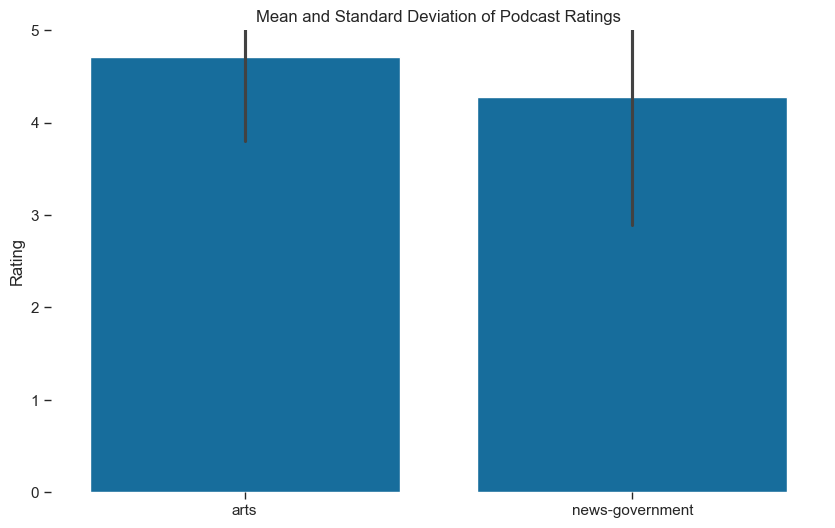

In [23]:
plt.figure(figsize=(10, 6))

ax = sns.barplot(data=arts_news_ratings, x="category", y="rating", errorbar="sd")


sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

plt.title("Mean and Standard Deviation of Podcast Ratings")
plt.xlabel("")
plt.ylabel("Rating")
plt.ylim(0, 5)
plt.yticks(range(6))

plt.show()

It is difficult to assess whether these two populations are different from one another. So, I will first get a confidence interval for these mean differences and then I will perform my hypothesis test. 

In [25]:
mean_arts = arts_news_ratings[arts_news_ratings["category"] == "arts"]["rating"].mean()
mean_news = arts_news_ratings[arts_news_ratings["category"] == "news-government"][
    "rating"
].mean()
best_estimate = mean_arts - mean_news
print(best_estimate)

0.42861954167609007


In [28]:
lower, upper = bootstrap_confidence_interval_two_means(
    arts_news_ratings[arts_news_ratings["category"] == "arts"]["rating"],
    arts_news_ratings[arts_news_ratings["category"] == "news-government"]["rating"],
)
print(f"95% Confidence Interval: ({lower:.3f}, {upper:.3f})")

95% Confidence Interval: (0.421, 0.437)


Our estimate sits within a pretty tight confidence interval due to such large sample sizes. There is about 0.42 to 0.43 point difference between how people rate these podcasts, that accounts for about 8.5% in how people rate each podcast. Is that statistically significant? 

Before running any tests, I must first check assumption of normality: 
- make a boxplot for each population
- make a Q-Q plot for each population 

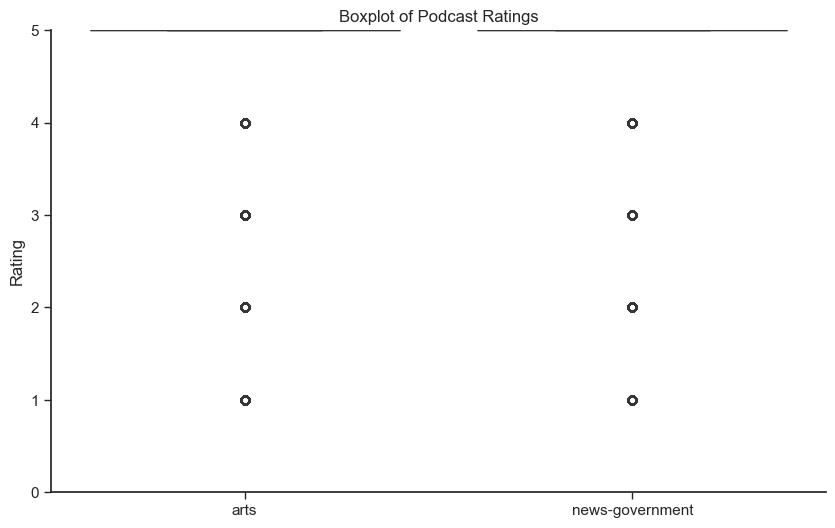

In [29]:
ax = sns.boxplot(data=arts_news_ratings, x="category", y="rating")

sns.despine(left=False, bottom=False, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)


plt.title("Boxplot of Podcast Ratings")
plt.xlabel("")
plt.ylabel("Rating")
plt.ylim(0, 5)
plt.yticks(range(6))

plt.show()

In [30]:
arts_ratings_vec = arts_news_ratings[
    arts_news_ratings["category"] == "arts"
].rating.values

news_ratings_vec = arts_news_ratings[
    arts_news_ratings["category"] == "news-government"
].rating.values

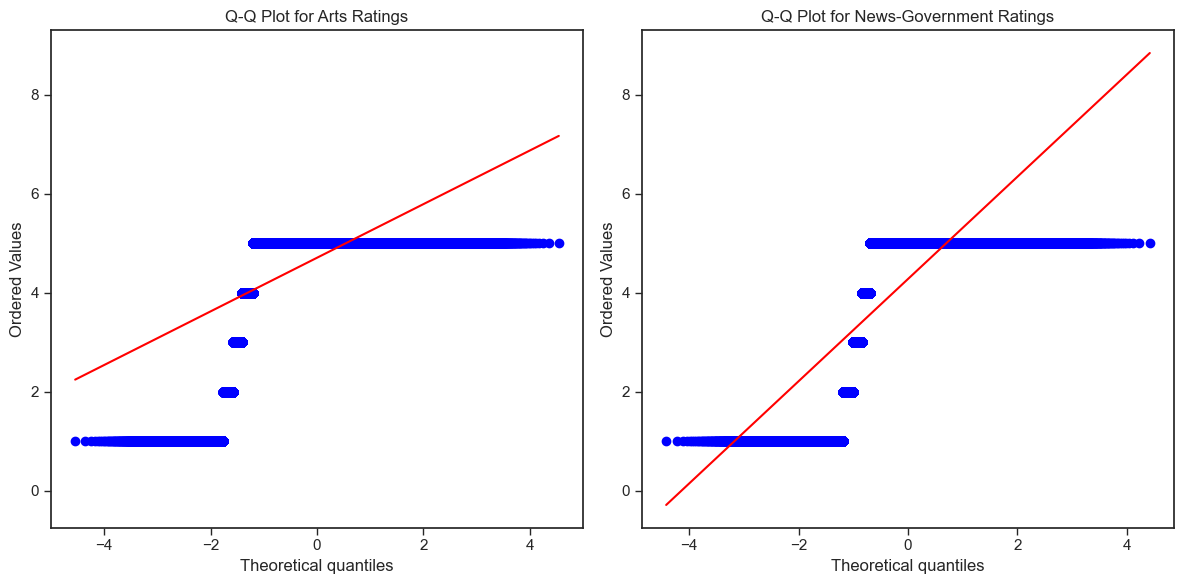

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
stats.probplot(arts_ratings_vec, plot=ax1)
ax1.set_title("Q-Q Plot for Arts Ratings")

stats.probplot(news_ratings_vec, plot=ax2)
ax2.set_title("Q-Q Plot for News-Government Ratings")

ax1.set_ylabel("Ordered Values")

for ax in (ax1, ax2):
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_tick_params(width=1, length=5)
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_tick_params(width=1, length=5)

plt.tight_layout()
plt.show()

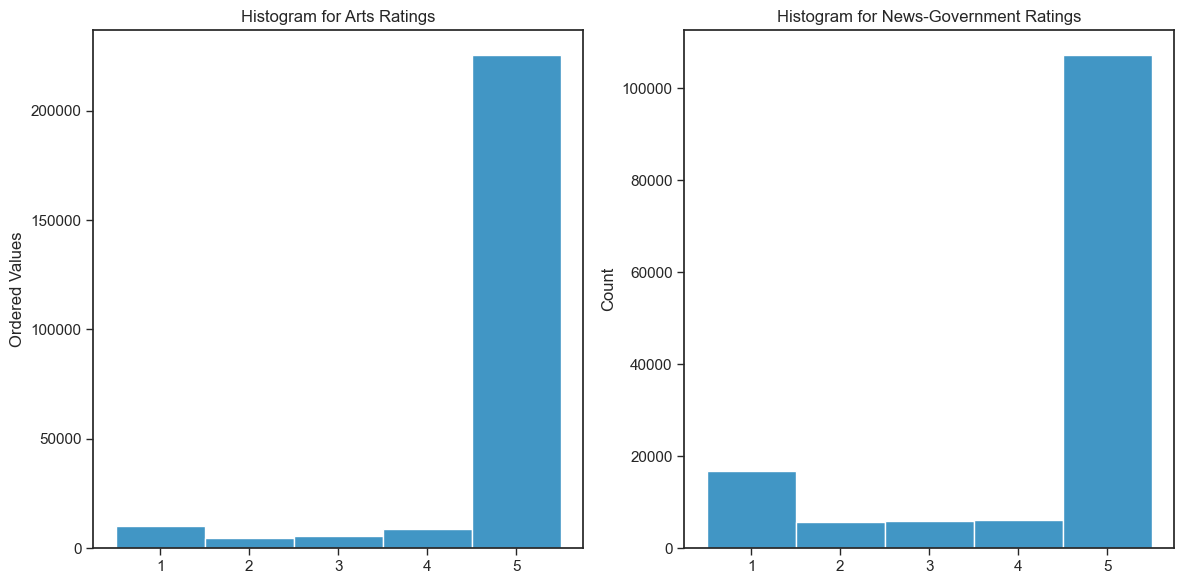

In [32]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=arts_ratings_vec, discrete=True, ax=ax1)
ax1.set_title("Histogram for Arts Ratings")

sns.histplot(data=news_ratings_vec, discrete=True, ax=ax2)
ax2.set_title("Histogram for News-Government Ratings")

ax1.set_ylabel("Ordered Values")

ax1.xaxis.set_ticks_position("bottom")
ax1.xaxis.set_tick_params(width=1, length=5)
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.set_tick_params(width=1, length=5)

ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_tick_params(width=1, length=5)
ax2.yaxis.set_ticks_position("left")
ax2.yaxis.set_tick_params(width=1, length=5)

plt.tight_layout()
plt.show()

In [33]:
num_arts = arts_news_ratings[arts_news_ratings["category"] == "arts"].shape[0]
num_news = arts_news_ratings[arts_news_ratings["category"] == "news-government"].shape[
    0
]
print(mean_diff_permutation(arts_news_ratings["rating"], num_arts, num_news))

0.0003359261171045347


In [34]:
perm_diffs = [
    mean_diff_permutation(arts_news_ratings["rating"], num_arts, num_news)
    for _ in range(1000)
]

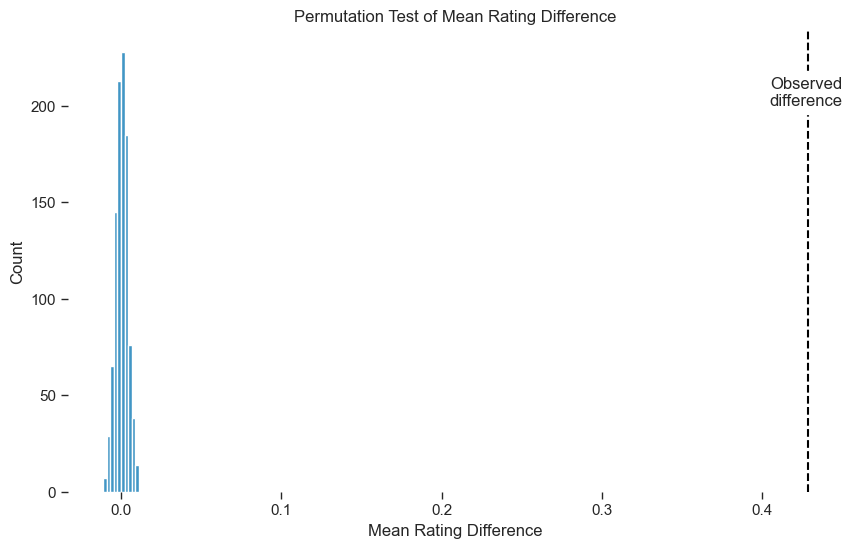

In [35]:
ax = sns.histplot(data=perm_diffs, bins=10)
ax.axvline(x=best_estimate, linestyle="--", color="black")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)
ax.text(0.405, 200, "Observed\ndifference", bbox={"facecolor": "white"})


plt.title("Permutation Test of Mean Rating Difference")
plt.xlabel("Mean Rating Difference")
plt.ylabel("Count")
plt.show()

In [36]:
p_value = np.mean([diff > best_estimate for diff in perm_diffs])
print(
    f"""
According to this permutation test the difference in the means 
that we observed would be observed due to chance {p_value*100}% of the time, p < 0.0001.
"""
)


According to this permutation test the difference in the means 
that we observed would be observed due to chance 0.0% of the time, p < 0.0001.



As one final assessment of the ratings that we observed for arts vs. news&government, we will perform a Chi-Squared test of independence to determine if the observed distribution deviates from expectation. 

In [37]:
arts_news_contingency = pd.crosstab(
    arts_news_ratings["category"], arts_news_ratings["rating"]
)
arts_news_contingency

rating,1.0,2.0,3.0,4.0,5.0
category,,,,,
arts,9921,4767,5656,8582,225413
news-government,16738,5600,6018,6099,107233


In [38]:
chi_squared, p, _, _ = chi2_contingency(arts_news_contingency)
print(
    f"""
Based on expectations, the current data presents a chi-squared statistic of {chi_squared:.4f}
, p<0.0001 (i.e.{p:.4f}. This suggests that the distributions observed are independent 
(i.e. deviate from an expected distribution) and are unlikely due to chance.
"""
)


Based on expectations, the current data presents a chi-squared statistic of 13256.1036
, p<0.0001 (i.e.0.0000. This suggests that the distributions observed are independent 
(i.e. deviate from an expected distribution) and are unlikely due to chance.



***
### Compare the category with the highest proportion of 5 star reviews to category with highest proportion of 1 star reviews

First, what are those categories? 

In [39]:
rating_proportions = (
    category_ratings.groupby("category").value_counts(normalize=True).reset_index()
)

five_star_max = rating_proportions[rating_proportions["rating"] == 5][
    "proportion"
].max()
print(rating_proportions[rating_proportions["proportion"] == five_star_max])

one_star_max = rating_proportions[rating_proportions["rating"] == 1]["proportion"].max()
print(rating_proportions[rating_proportions["proportion"] == one_star_max])

   category  rating  proportion
5  business     5.0    0.940818
           category  rating  proportion
51  news-government     1.0    0.123038


So, business has the most 5-star reviews and news&government has the most 1-star reviews 

But __do these podcasts differ with regard to  what proportion of 3-star (i.e. "lukewarm") reviews each of these categories get?__ 

I would be quite surprised if a different amount of people would feel lukewarm about a podcast and give it 3-star rating regardless of whether a podcast is particularly liked, or particularly disliked.

_population 1:_ three-star reviews of business podcasts <br>
_population 2:_ three-star reviews of news-government podcasts

parameter of interest: $p_{1}$ - $p_{2}$ , i.e. difference in proportion of 3-star ratings between groups

note: $p$ here represents the proportion of 3-star ratings

null hypothesis $H_{0}$: $p_{1}$ = $p_{2}$ (i.e. no difference, $p_{1}$ - $p_{2}$ = 0)
and alternative hypothesis $H_{0}$: $\theta_{1}$ $\neq$ $\theta_{2}$ (i.e. some difference, $p_{1}$ - $p_{2}$ $\neq$ 0)

I will assess this at a $\alpha$-level = 0.05

assumptions: 
- independent simple random samples
- normality / "large enough" sample size to invoke central limit theorem

In [40]:
biz_news_ratings = main_ratings_df[["reviewer", "rating", "category"]][
    (main_ratings_df["category"] == "business")
    | (main_ratings_df["category"] == "news-government")
]

biz_news_ratings

,reviewer,rating,category
31,A7A972EC484B528,5.0,business
32,7D68FF21C4E5A86,5.0,business
33,2E583AA6ADE7E2D,5.0,business
34,517DFDA7B975B4C,5.0,business
35,925505304DEF730,5.0,business
...,...,...,...
2041710,B4AF35070E90B91,5.0,business
2041711,E39276E137EE21F,5.0,business
2041712,4691664311C6211,5.0,business
2041713,C8EB2CEE0B67BE9,5.0,business


assumption of independent simple random samples: 

While I can not ensure a SRS (I will assume this for sake of analysis), I can ensure that our sample does not have any members in both samples

In [41]:
duplicate_reviewers = (
    biz_news_ratings.groupby(["reviewer", "category"]).size().unstack()
)
duplicate_reviewers = duplicate_reviewers[
    (duplicate_reviewers["business"] > 0) & (duplicate_reviewers["news-government"] > 0)
]
biz_news_ratings = biz_news_ratings[
    ~biz_news_ratings["reviewer"].isin(duplicate_reviewers.index)
]
biz_news_ratings

,reviewer,rating,category
31,A7A972EC484B528,5.0,business
32,7D68FF21C4E5A86,5.0,business
33,2E583AA6ADE7E2D,5.0,business
34,517DFDA7B975B4C,5.0,business
35,925505304DEF730,5.0,business
...,...,...,...
2041710,B4AF35070E90B91,5.0,business
2041711,E39276E137EE21F,5.0,business
2041712,4691664311C6211,5.0,business
2041713,C8EB2CEE0B67BE9,5.0,business


Before getting too far into the analysis, what do these two groups look like?

In [42]:
biz_news_ratings.groupby("category").describe()

rating                                             
                    count      mean       std  min  25%  50%  75%  max
category                                                              
business         203667.0  4.856589  0.662435  1.0  5.0  5.0  5.0  5.0
news-government  150788.0  4.264524  1.403911  1.0  5.0  5.0  5.0  5.0

In [43]:
biz_news_ratings_counts = (
    biz_news_ratings[["rating", "category"]]
    .groupby("category")
    .value_counts()
    .unstack()
    .reset_index()
)
biz_news_ratings_counts

rating,category,1.0,2.0,3.0,4.0,4.5,5.0
0,business,4204.0,1636.0,2045.0,3393.0,2.0,192387.0
1,news-government,18176.0,6090.0,6604.0,6719.0,NaN,113199.0


When I look at these data I notice a few things:
- the business group is larger than the news&government group, hence more reviews.
- There are in fact more 5 star reviews.
- Although at first I expected that the proportion of 3-star reviews would not differ, it does appear like there are many more "lukewarm" 3-star reviews proportionally for business podcasts. 

Now I will generate proportions of 3-star counts from these data in order to assess this observation quantitatively. Although my visual assessment differs from the null distribution, does the data in fact differ in this way? 

In [44]:
biz_news_ratings_totals = biz_news_ratings_counts.set_index("category").sum(axis=1)
biz_totals = biz_news_ratings_totals.values[0]
news_totals = biz_news_ratings_totals.values[1]

In [45]:
biz_3_star_cts = biz_news_ratings_counts[
    biz_news_ratings_counts["category"] == "business"
][3.0].values
biz_proportion = biz_3_star_cts / biz_totals
biz_proportion = biz_proportion[0]

In [46]:
news_3_star_cts = biz_news_ratings_counts[
    biz_news_ratings_counts["category"] == "news-government"
][3.0].values
news_proportion = news_3_star_cts / news_totals
news_proportion = news_proportion[0]

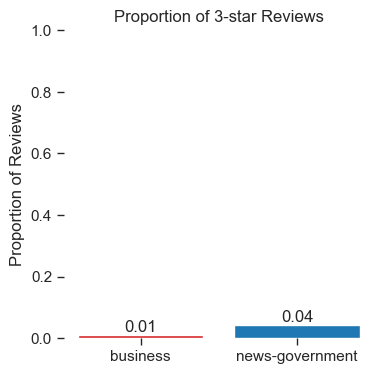

In [47]:
_, ax = plt.subplots(figsize=(4, 4))

podcasts = ["business", "news-government"]
proportions = [biz_proportion, news_proportion]
bar_labels = ["business", "news-government"]
bar_colors = ["tab:red", "tab:blue"]

bars = ax.bar(podcasts, proportions, label=bar_labels, color=bar_colors)

for bar, proportion in zip(bars, proportions):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{proportion:.2f}",
        ha="center",
        va="bottom",
    )

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

ax.set_ylabel("Proportion of Reviews")
ax.set_title("Proportion of 3-star Reviews")
ax.set_ylim(0, 1)

plt.show()

In [49]:
best_estimate = biz_proportion - news_proportion
print(best_estimate)

-0.033755688491224775


As we can see, the difference here is that group 2, news&government has a larger proportion of 3-star ratings by about 3%. Is this significant? 

My approach will be:
- Calculate a confidence interval for these estimates using standard methods
- Perform a hypothesis test based on normal assumptions followed by a resampling approach
- Perform a chi-square test directly on the counts

In [51]:
CI_low, CI_up = sm.stats.confint_proportions_2indep(
    biz_3_star_cts,
    biz_totals,
    news_3_star_cts,
    news_totals,
    compare="diff",
    alpha=0.05,
    correction=True,
)
print(f"95% Confidence Interval: {CI_low}, {CI_up}")

95% Confidence Interval: [-0.03488298], [-0.03264268]


Notice that 0 is not in this confidence interval, hence, it is possible that there are  It is actually a very small confidence interval, so it could be that there are in fact more people providing 3-star reviews to news podcasts than to business podcasts

Assumption:<br>
If I am to run a normal hypothesis test, then I need to assess is that my sample sizes are sufficiently large, a rule of thumb follows the assertions below. Although we have huge sample sizes, I will perform these assertions for good practice before running a hypothesis test.

In [52]:
total_3_star_proportion = (biz_3_star_cts + news_3_star_cts) / (
    biz_totals + news_totals
)

assert biz_totals * total_3_star_proportion > 10, "Assumptions not met"
assert news_totals * total_3_star_proportion > 10, "Assumptions not met"
assert biz_totals * (1 - total_3_star_proportion) > 10, "Assumptions not met"
assert news_totals * (1 - total_3_star_proportion) > 10, "Assumptions not met"

In [53]:
statistic, p = sm.stats.test_proportions_2indep(
    biz_3_star_cts,
    biz_totals,
    news_3_star_cts,
    news_totals,
    compare="diff",
    alternative="two-sided",
    return_results=False,
)

print(
    f"""
    Assuming a normal distrubtion, comparing the proportions of business podcast reviews to 
    news & government podcast reviews, there appear to be differences in how many reviewers 
    feel lukewarm (defined by 3-star reviews) about those podcasts, Z={round(statistic.item(),4)}, 
    p < 0.001 (i.e. p={p.item()}).
    """
)


    Assuming a normal distrubtion, comparing the proportions of business podcast reviews to 
    news & government podcast reviews, there appear to be differences in how many reviewers 
    feel lukewarm (defined by 3-star reviews) about those podcasts, Z=-59.0691, 
    p < 0.001 (i.e. p=0.0).
    


To my genuine surprise, this appears to be a significant difference. However, this could also just be because there is such a large sample size that little differences are amplified in magnitude. 

Let's assess this same thing with a resampling approach. 

In [54]:
three_star = biz_news_ratings[(biz_news_ratings["rating"] == 3)]
three_star = three_star["category"]
proportion_diff_permutation(three_star, int(biz_3_star_cts[0]), int(news_3_star_cts[0]))

np.float64(0.516150913945612)

In [55]:
perm_diffs = [
    100
    * proportion_diff_permutation(
        three_star, int(biz_3_star_cts[0]), int(news_3_star_cts[0])
    )
    for _ in range(1000)
]

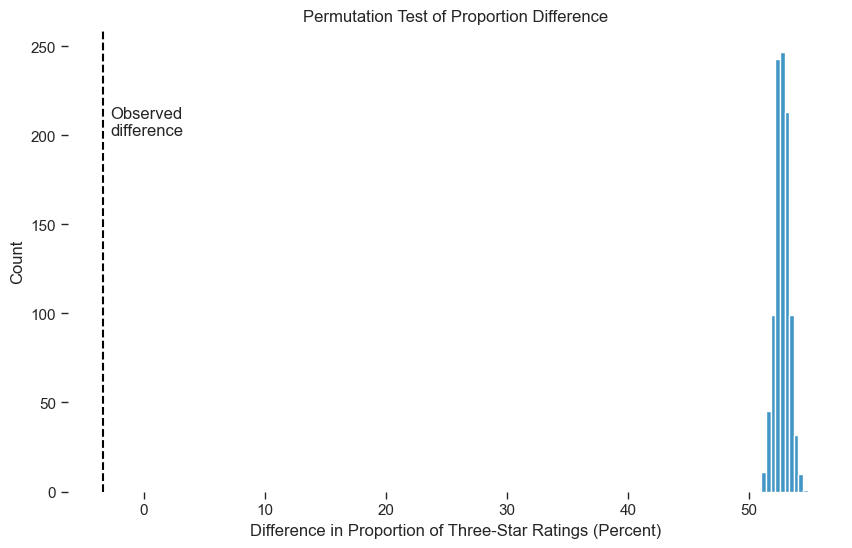

In [56]:
ax = sns.histplot(data=perm_diffs, bins=10)
ax.axvline(x=best_estimate * 100, linestyle="--", color="black")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)
ax.text(-2.8, 200, "Observed\ndifference", bbox={"facecolor": "white"})


plt.title("Permutation Test of Proportion Difference")
plt.xlabel("Difference in Proportion of Three-Star Ratings (Percent)")
plt.ylabel("Count")
plt.show()

In [57]:
biz_news_contingency = pd.DataFrame(
    {
        "buisness": [int(biz_3_star_cts[0]), int(biz_totals - biz_3_star_cts[0])],
        "news": [int(news_3_star_cts[0]), int(news_totals - news_3_star_cts[0])],
    },
    index=["three-star", "not three-star"],
)
biz_news_contingency

,buisness,news
three-star,2045,6604
not three-star,201622,144184


In [58]:
result = chi2_contingency(biz_news_contingency)
print("Based on the expected distribution of counts:")
pd.DataFrame(
    result.expected_freq,
    columns=["business", "news"],
    index=["three-star", "not three-star"],
)
print(
    f"""and an alpha-level of 0.05, we would reject the null hypothesis that there is not association between these variables.
         based on these data it appears that there is an associated with these variables (chi-square={result.statistic:.3f}, p<0.0001, (i.e. p={result.pvalue}))."""
)

Based on the expected distribution of counts:
and an alpha-level of 0.05, we would reject the null hypothesis that there is not association between these variables.
         based on these data it appears that there is an associated with these variables (chi-square=4145.678, p<0.0001, (i.e. p=0.0)).


***
### Length of Comedy Podcast Reviews
Does the length of a podcast review vary based on whether it is a 1 star review or a 5 star review? <br>
Due to the size of the dataset, I will only focus on comedy podcasts

In [59]:
one_star_reviews = main_ratings_df[
    (main_ratings_df["rating"] == 1) & (main_ratings_df["category"] == "comedy")
].copy()
one_star_reviews["review_length"] = one_star_reviews["review_content"].apply(len)
one_star_reviews = one_star_reviews.drop(
    columns=["podcast_name", "review_content", "category"]
)
one_star_reviews

,reviewer,rating,review_length
147,949D9945B294BAE,1.0,21
218,0738265DAF46E55,1.0,31
3605,87CB4205F4AA713,1.0,81
12281,9E358998F1B7285,1.0,861
12317,6529F60BA631AFD,1.0,25
...,...,...,...
2040835,F170D53C099D6C9,1.0,22
2040960,93110D8BB9FC8C0,1.0,39
2040962,674093130463D9E,1.0,24
2040966,68915DE92B3586B,1.0,63


In [60]:
five_star_reviews = main_ratings_df[
    (main_ratings_df["rating"] == 5) & (main_ratings_df["category"] == "comedy")
].copy()
five_star_reviews["review_length"] = five_star_reviews["review_content"].apply(len)
five_star_reviews = five_star_reviews.drop(
    columns=["podcast_name", "review_content", "category"]
)
five_star_reviews

,reviewer,rating,review_length
14,A2511C7B759BD0F,5.0,515
15,A747C31F1CCA2E7,5.0,80
16,7A976A1EF1892D2,5.0,401
17,6E7DF65C3BE51F8,5.0,663
18,31C376680AA9CB7,5.0,142
...,...,...,...
2041214,A37F623A57453B7,5.0,28
2041215,7155F5D775C4A60,5.0,25
2041216,CBF27E14C290820,5.0,75
2041217,95DF98782551739,5.0,65


in order to assume independence of SRS, I will make sure that there are no duplicates in each group 

In [61]:
five_star_reviews = five_star_reviews[
    ~five_star_reviews["reviewer"].isin(one_star_reviews["reviewer"])
]
one_star_reviews = one_star_reviews[
    ~one_star_reviews["reviewer"].isin(five_star_reviews["reviewer"])
]
review_length_df = pd.concat(
    [one_star_reviews, five_star_reviews], ignore_index=True, axis=0
)

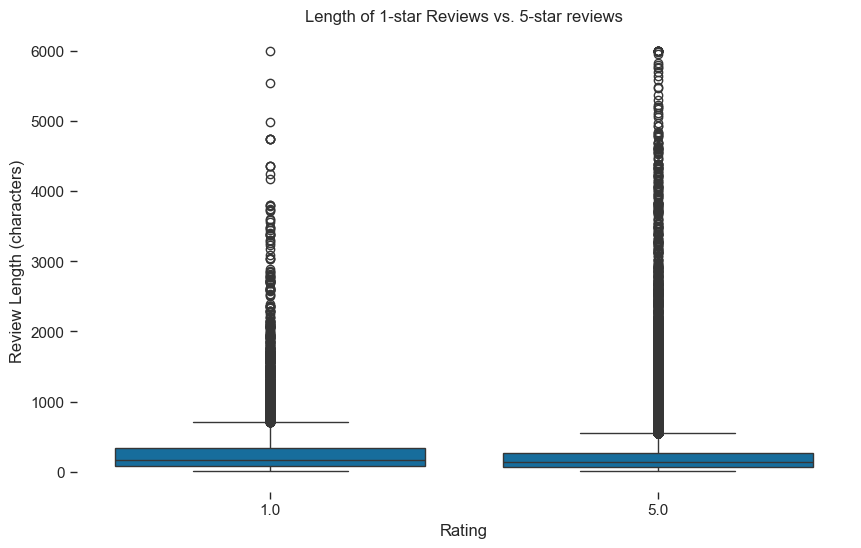

In [78]:
ax = sns.boxplot(data=review_length_df, x="rating", y="review_length")
plt.title("Length of 1-star Reviews vs. 5-star reviews")
plt.ticklabel_format(style="plain", axis="y")
plt.xlabel("Rating")
plt.ylabel("Review Length (characters)")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)

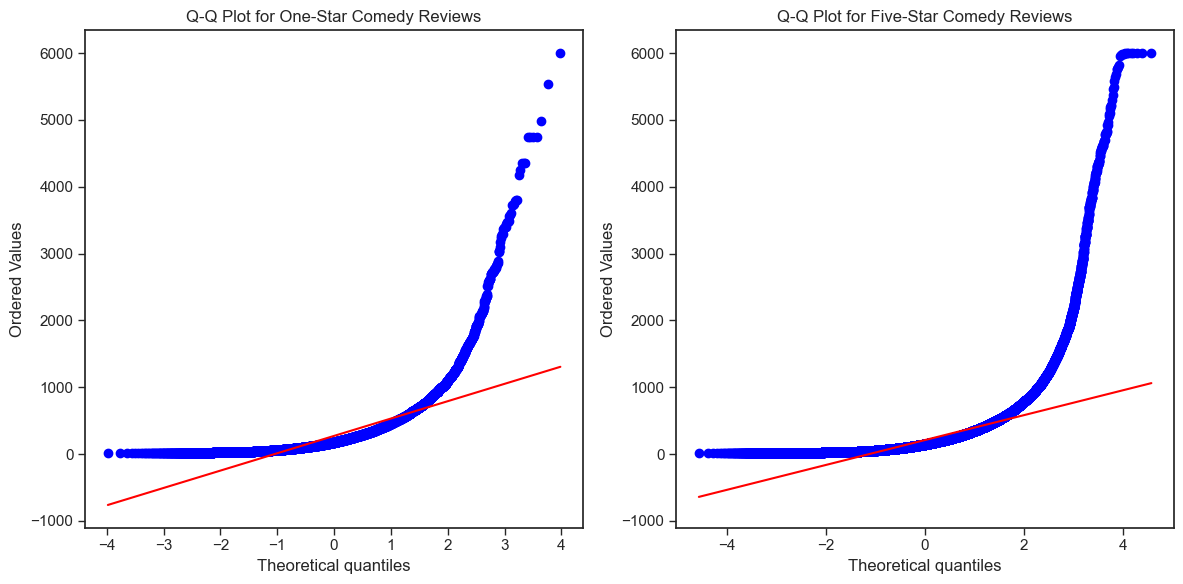

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
stats.probplot(one_star_reviews["review_length"], plot=ax1)
ax1.set_title("Q-Q Plot for One-Star Comedy Reviews")

stats.probplot(five_star_reviews["review_length"], plot=ax2)
ax2.set_title("Q-Q Plot for Five-Star Comedy Reviews")

ax1.set_ylabel("Ordered Values")

for ax in (ax1, ax2):
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_tick_params(width=1, length=5)
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_tick_params(width=1, length=5)

plt.tight_layout()
plt.show()

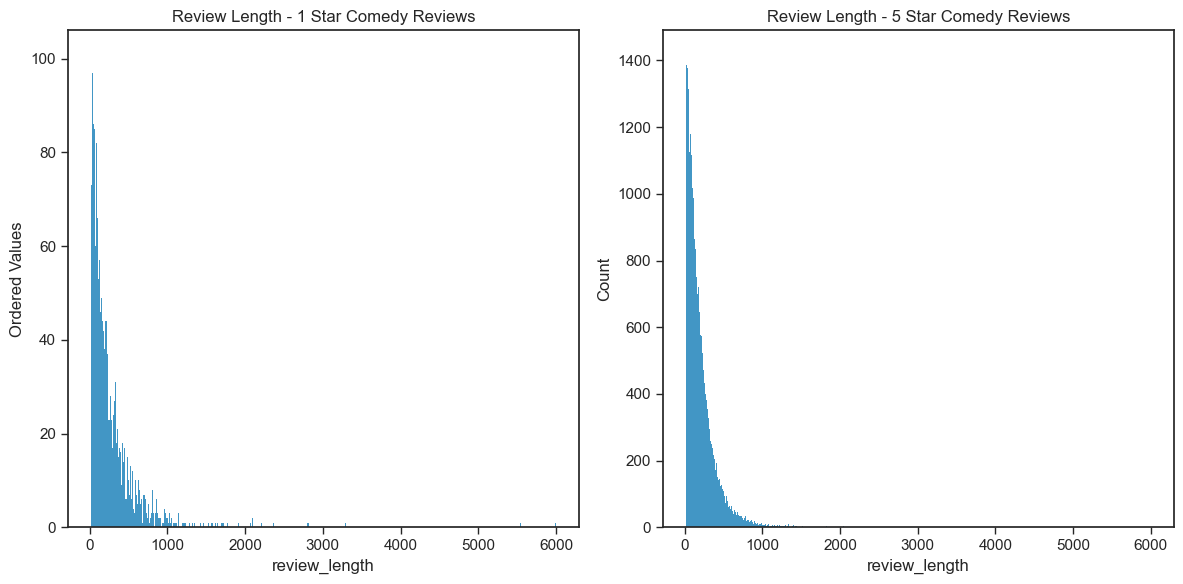

In [64]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=one_star_reviews["review_length"], discrete=True, ax=ax1)
ax1.set_title("Review Length - 1 Star Comedy Reviews")

sns.histplot(data=five_star_reviews["review_length"], discrete=True, ax=ax2)
ax2.set_title("Review Length - 5 Star Comedy Reviews")

ax1.set_ylabel("Ordered Values")

ax1.xaxis.set_ticks_position("bottom")
ax1.xaxis.set_tick_params(width=1, length=5)
ax1.yaxis.set_ticks_position("left")
ax1.yaxis.set_tick_params(width=1, length=5)

ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_tick_params(width=1, length=5)
ax2.yaxis.set_ticks_position("left")
ax2.yaxis.set_tick_params(width=1, length=5)

plt.tight_layout()
plt.show()

Since these distributions are both definitely not normal (right skewed), it does not make sense to use parametric tests to test whether there is any difference in the length of 5-star reviews and 1-star reviews of comedy podcasts.

Instead, I will take 2 separate approaches. 
First, I will take the approach of using resampling approaches:
- bootstrapped confidence interval
- test hypothesis against the null distribution created by permutation testing 

in all cases the null distribution suggests that there is no difference between the groups.

__population 1__: One-Star Reviews of Comedy Podcasts <br>
__population 2__: Five-Star Reviews of Comedy Podcasts

$H_{0}$: Length of 1-Star Comedy Podcast Reviews = Length of 5-Star Comedy Podcast Reviews <br>
$H_{a}$: Length of 1-Star Comedy Podcast Reviews $\neq$ Length of 5-Star Comedy Podcast Reviews

Parameter of Interest:$\mu_{1}$ - $\mu_{2}$ <br>
(Average Length of Comedy Podcast 1-Star Reviews - Average Length of Comedy Podcast 5-Star Reviews)

$\alpha$-level = 0.05

I will perform a 2-way test. 

first I will generate a bootstrapped confidence interval for the difference between two mean review lengths

In [66]:
best_estimate = np.mean(one_star_reviews["review_length"]) - np.mean(
    five_star_reviews["review_length"]
)
print(best_estimate)

61.684093957171285


In [69]:
ci_lower, ci_upper = bootstrap_confidence_interval_two_means(
    one_star_reviews["review_length"], five_star_reviews["review_length"]
)

print(f"Bootstrap Confidence Interval (95%): ({ci_lower:.3f}, {ci_upper:.3f})")

Bootstrap Confidence Interval (95%): (56.817, 66.594)


I will now calculate a permutation test for these sample means and a null distribution 

In [71]:
size_one_star = one_star_reviews["review_length"].size
size_five_star = five_star_reviews["review_length"].size
print(mean_diff_permutation(review_length_df["review_length"], size_one_star, size_five_star))

-0.7322586813781413


In [72]:
perm_diffs = [
    mean_diff_permutation(
        review_length_df["review_length"], size_one_star, size_five_star
    )
    for _ in range(1000)
]

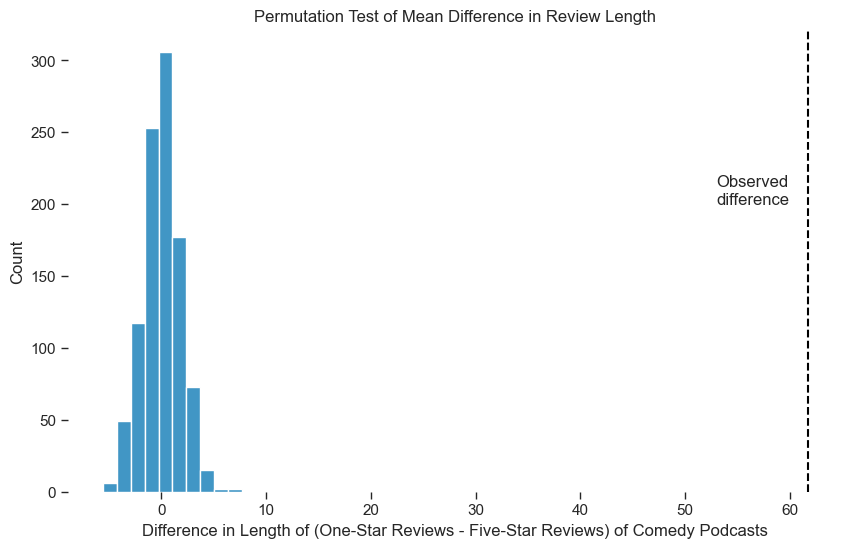

In [73]:
ax = sns.histplot(data=perm_diffs, bins=10)
ax.axvline(x=best_estimate, linestyle="--", color="black")

sns.despine(left=True, bottom=True, right=True, top=True)
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(width=1, length=5)
ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(width=1, length=5)
ax.text(53, 200, "Observed\ndifference", bbox={"facecolor": "white"})


plt.title("Permutation Test of Mean Difference in Review Length")
plt.xlabel(
    "Difference in Length of (One-Star Reviews - Five-Star Reviews) of Comedy Podcasts"
)
plt.ylabel("Count")
plt.show()

Notice that the difference is not one that falls anywhere close to the null permutation distribution.

it appears that one star reviews are longer than five star reviews by approximately 56 characters

*** 
## Paired Samples -- Does the same reviewer give similar ratings to two different podcasts? 

For this I am choosing two popular political podcasts amongsts American Liberals, "The Daily" and "Pod Save America" and looking at the ratings of shared reviewers. We have seen sufficient evidence that data from ratings does not follow a normal distribution, so instead of testing for normality, I will jump directly to a non-parametric test, the Wilcoxon signed-rank test for paired samples. 

The first challenge is to get clean paired simple random samples. For this I chose to focus on only these two podcasts and get uses that have only reviewed each podcast once. 

__population__: reviewers of The Daily and Pod Save America <br>
__sample__: reviewers who reviewed The Daily and Pod Save America both exactly once 

Null Hypothesis: Those who rate one podcast with rate the second podcast similarly.<br> 
                 Rating 1 = Rating 2

$\alpha-level$ = 0.05

In [74]:
lib_pods = main_ratings_df[["podcast_name", "reviewer", "rating"]][
    (main_ratings_df["podcast_name"] == "The Daily")
    | (main_ratings_df["podcast_name"] == "Pod Save America")
]
grouped = (
    lib_pods.groupby(["reviewer", "podcast_name"])
    .size()
    .reset_index(name="rating_count")
)
pivot_table = grouped.pivot(
    index="reviewer", columns="podcast_name", values="rating_count"
).fillna(0)
filtered_reviewers = pivot_table[
    (pivot_table["Pod Save America"] == 1) & (pivot_table["The Daily"] == 1)
]
reviewer_names = filtered_reviewers.index.tolist()
filtered_df = lib_pods[lib_pods["reviewer"].isin(reviewer_names)]
common_daily = filtered_df[filtered_df["podcast_name"] == "The Daily"]
common_pod_save = filtered_df[filtered_df["podcast_name"] == "Pod Save America"]
merged_df = pd.merge(
    common_daily, common_pod_save, on="reviewer", suffixes=("_Daily", "_PSA")
)
merged_df

,podcast_name_Daily,reviewer,rating_Daily,podcast_name_PSA,rating_PSA
0,The Daily,231B095194D63F7,1.0,Pod Save America,1.0
1,The Daily,840FE4C2626D25F,1.0,Pod Save America,1.0
2,The Daily,B568A6AFA6FCAA5,3.0,Pod Save America,1.0
3,The Daily,17D1D310138BA37,3.0,Pod Save America,5.0
4,The Daily,74F1D46CAE6812E,3.0,Pod Save America,3.0
...,...,...,...,...,...
84,The Daily,2C5D530277B4020,3.0,Pod Save America,4.0
85,The Daily,4E5B0A17EBB698B,3.0,Pod Save America,5.0
86,The Daily,9A0B8FC79F629EC,1.0,Pod Save America,1.0
87,The Daily,3FCAFAE6ED37766,2.0,Pod Save America,1.0


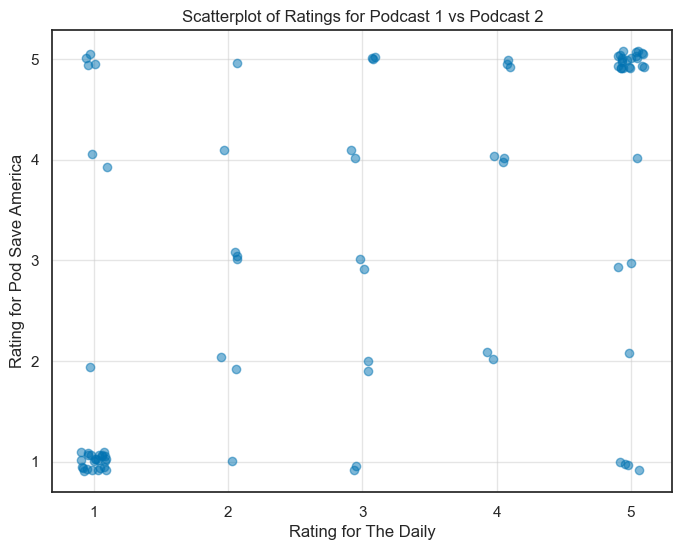

In [75]:
jitter = 0.1
merged_df["rating_Daily_jittered"] = merged_df["rating_Daily"] + np.random.uniform(
    -jitter, jitter, size=len(merged_df)
)
merged_df["rating_PSA_jittered"] = merged_df["rating_PSA"] + np.random.uniform(
    -jitter, jitter, size=len(merged_df)
)

plt.figure(figsize=(8, 6))
plt.scatter(
    merged_df["rating_Daily_jittered"], merged_df["rating_PSA_jittered"], alpha=0.5
)
plt.title("Scatterplot of Ratings for Podcast 1 vs Podcast 2")
plt.xlabel("Rating for The Daily")
plt.ylabel("Rating for Pod Save America")
plt.grid(True)
plt.show()

In [76]:
statistic, p_value = wilcoxon(common_daily.rating, common_pod_save.rating)

print("Wilcoxon signed-rank test:")
print("Statistic:", statistic)
print("p-value:", p_value)

alpha = 0.05
if p_value < alpha:
    print(
        "Reject the null hypothesis: There is evidence that the ratings differ between the two podcasts."
    )
else:
    print(
        "Fail to reject the null hypothesis: There is no evidence that the ratings differ between the two podcasts."
    )

Wilcoxon signed-rank test:
Statistic: 867.0
p-value: 0.7213920285156985
Fail to reject the null hypothesis: There is no evidence that the ratings differ between the two podcasts.


According to this non-parametric test of paired-samples, those who rate both podcasts do not appear to do so differently. 

***
## Conclusions:
#### - 5-star reviews are the most common for all categories
#### - Most podcasts are rated similarly (5-stars)
#### - Ratings are not normally distributed
#### - Negatively reviewed podcast categories (e.g. News-Government) get more 3-star reviewed than positively reviewed podcast categories (e.g. Business)
#### - 1-star reviews are slightly longer than 5-star reviews
#### - People who rate two podcasts do so similarly

#### Future Directions
This analysis could be improved by deeper consideration of more continuous quantitative variables such as time-series (e.g. datetime variables) or by creating new features through text analysis or sentimentality analysis. In general, this notebook could be simplified. Lastly, the statistical analyses performed may have been beyond what is necessary for these data. However, I wanted to use this opportunity to practice specific techniques such as hypothesis testing even though the data did not readily lend themselves to those techniques. <br>

***

__Looker Studio Dashboard__

To see a basic Looker Dashboard built from this database click [here](https://lookerstudio.google.com/reporting/4b70c021-6318-464d-aacb-676f92817f84)